# CartoonGAN 논문의 모델 구조
<img src="https://aruie.github.io/assets/post/191114-01.png" width=700>


# 참고자료
- OpenCV 참고 : https://opencv-python.readthedocs.io/en/latest/doc/01.imageStart/imageStart.html

In [109]:
# Google Drive mount
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [110]:
# import
import os
import matplotlib.pyplot as plt
import PIL
import PIL.Image
import tensorflow as tf
from matplotlib.image import imread
import cv2
import numpy as np

# 이미지 파일명 담은 리스트 생성

In [111]:
image_path = '/content/drive/MyDrive/GoogleColab/CartoonGAN_Project/cartoon_data/벼랑위에 포뇨.mp4'

# 이미지 파일명을 담은 리스트 생성
imageName_list = os.listdir(image_path)
print(imageName_list[:10])  # 이미지 파일명 10개 출력
print(len(imageName_list))

['벼랑위에 포뇨.mp4_000967174.png', '벼랑위에 포뇨.mp4_000972179.png', '벼랑위에 포뇨.mp4_000977184.png', '벼랑위에 포뇨.mp4_000982189.png', '벼랑위에 포뇨.mp4_000987194.png', '벼랑위에 포뇨.mp4_000992199.png', '벼랑위에 포뇨.mp4_000997204.png', '벼랑위에 포뇨.mp4_001002209.png', '벼랑위에 포뇨.mp4_001007214.png', '벼랑위에 포뇨.mp4_001012219.png']
1190


# 이미지 확인

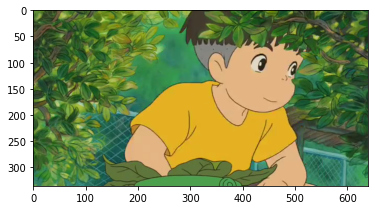

(336, 640, 3)
336
640


In [112]:
img_bgr = cv2.imread(image_path + '/' + imageName_list[0])  # OpenCV -> BGR 순서로 컬러 이미지 저장함
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)  # BGR -> RGB로 순서 바꿔주기
plt.imshow(img)
plt.show()

print(img.shape)
print(img.shape[0])
print(img.shape[1])

# 이미지 300x300 crop
- resizing을 하여 이미지를 300x300으로 줄이지 않고 crop을 하는 이유?
- 배치 사이즈를 키우고 처리 속도를 빠르게 하기 위한 목적
- 배치 사이즈가 작다 -> gradient값 부저왁, 수렴속도 매우 느려짐, 혹은 때때로 loss값이 발산하는 경우 발생할수도 있음
- resizing을 하게 되면 downsize하는 과정에서 학습하지 않아도 될 artifact가 생길수가 있다.
- 하지만, crop size가 너무 작게 되면 CNN에서 오히려 feature를 잡아내지 못할 수 있다.
- 또한, 데이터셋의 크기를 늘리는 것과 같은 효과를 얻을 수 있다.

In [113]:
# 원본 이미지에서 (300, 300) 사이즈로 크롭하자.


crop_path = "/content/drive/MyDrive/GoogleColab/CartoonGAN_Project/cartoon_data/벼랑위에 포뇨.mp4_crop"
# crop된 이미지를 넣을 디렉토리 생성
!mkdir -p crop_path
# 옵션 -p : 디렉토리가 없을 때 생성한다.

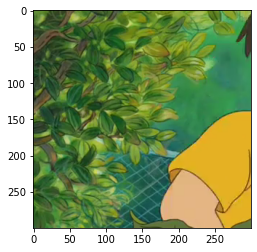

In [114]:
# 맨 왼쪽위부터 300x300 crop
img_left_crop = img[0:0+300, 0:0+300]
plt.imshow(img_left_crop)
plt.show()

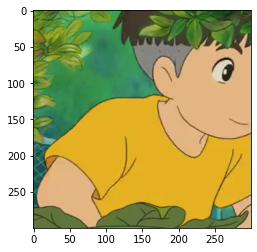

In [115]:
# 가운데 300x300 crop
img_middle_crop = img[int(img.shape[0]/2)-150:int(img.shape[0]/2)+150, int(img.shape[1]/2)-150:int(img.shape[1]/2)+150]
plt.imshow(img_middle_crop)
plt.show()

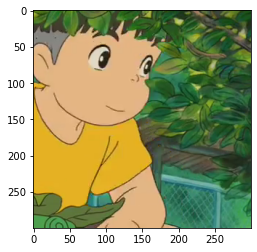

In [116]:
# 맨 오른쪽 아래부터 300x300 crop
img_right_crop = img[img.shape[0]-300:img.shape[0], img.shape[1]-300:img.shape[1]]
plt.imshow(img_right_crop)
plt.show()

# 300x300 만화 이미지 -> edge smoothing
1. canny edge detector로 엣지 검출
2. 엣지 영역 확장
3. 엣지에 Gaussian filter 적용

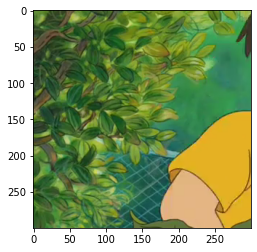

In [117]:
# 원본 이미지 다시 확인
plt.imshow(img_left_crop)
plt.show()

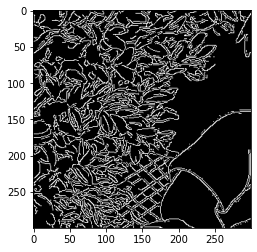

In [118]:
edges_left = cv2.Canny(img_left_crop, 100, 200)  # (엣지 검출할 이미지, threshold 최소값, threshold 최대값)
plt.imshow(edges_left, 'gray')
plt.show()

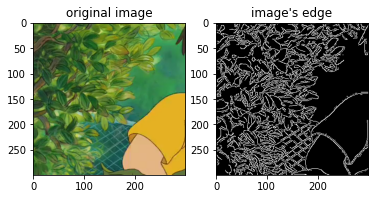

In [119]:
plt.subplot(1, 2, 1)
plt.imshow(img_left_crop)
plt.title('original image')

plt.subplot(1, 2, 2)
plt.imshow(edges_left, 'gray')
plt.title("image's edge")

plt.show()

In [120]:
# 이 정도면 엣지 검출이 잘 된 것 같다.
# 다음 단계로 넘어가자.

In [121]:
# 가우시안 1D 커널 생성
# cv2.getGaussianKernel(kernel size, sigma)
kernel1d = cv2.getGaussianKernel(5, 3)
print(kernel1d)

[[0.17820326]
 [0.21052227]
 [0.22254894]
 [0.21052227]
 [0.17820326]]


In [122]:
# 가우시안 2D 커널 생성 : 가우시안 1D 커널을 외적
# np.outer(kernel1d, kernel1d.transpose())
kernel2d = np.outer(kernel1d, kernel1d.transpose())
print(kernel2d)

[[0.0317564  0.03751576 0.03965895 0.03751576 0.0317564 ]
 [0.03751576 0.04431963 0.04685151 0.04431963 0.03751576]
 [0.03965895 0.04685151 0.04952803 0.04685151 0.03965895]
 [0.03751576 0.04431963 0.04685151 0.04431963 0.03751576]
 [0.0317564  0.03751576 0.03965895 0.03751576 0.0317564 ]]


In [123]:
# 엣지 부분에 가우시안 커널을 적용(convolve 해줌)

print(edges_left)
print(type(edges_left))
print(edges_left.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
<class 'numpy.ndarray'>
(300, 300)


In [124]:
# 엣지가 numpy의 array 형태이기 때문에 굳이 np.asarray 함수를 이용하여
# array 형태로 바꿔줄 필요 없음.

# 엣지 부분에 가우시안 필터 convolve
edges_left_after_gaussian = cv2.filter2D(edges_left, -1, kernel2d)
print(edges_left_after_gaussian)

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  8 10 10]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


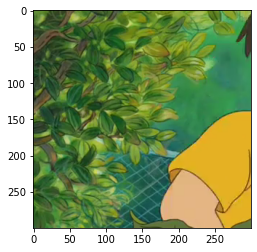

In [125]:
# 원본 이미지는 컬러 이미지(RGB, 3채널)
# 하지만 가우시안 2D 필터는 1채널
# 어떻게 계산?

# RGB 채널을 각각 R, G, B로 분리한 후, 
# 원래의 엣지부분을
# 각 R, G, B에 가우시안 필터가 적용된 엣지로 바꾸자.

plt.imshow(img_left_crop)  # 원본 이미지
plt.show()

In [126]:
print(img_left_crop.shape)  # 원본 이미지의 shape
print(np.array(img_left_crop))  # 원본 이미지를 np.array로 보면

(300, 300, 3)
[[[ 91 135  45]
  [ 98 142  52]
  [ 99 143  55]
  ...
  [158 184  86]
  [152 178  88]
  [156 182  91]]

 [[ 96 141  50]
  [100 144  54]
  [100 144  56]
  ...
  [158 184  86]
  [150 176  85]
  [156 182  91]]

 [[103 146  65]
  [100 143  62]
  [ 98 141  58]
  ...
  [161 186  88]
  [153 180  89]
  [156 182  91]]

 ...

 [[ 52 109  67]
  [ 38  95  53]
  [ 54  95  53]
  ...
  [ 96 117  60]
  [ 96 117  60]
  [ 96 117  60]]

 [[ 51 112  75]
  [ 37  98  61]
  [ 56  96  62]
  ...
  [ 96 117  62]
  [ 96 117  62]
  [ 96 117  62]]

 [[ 54 115  79]
  [ 38  99  62]
  [ 57  97  63]
  ...
  [ 96 117  62]
  [ 96 117  62]
  [ 96 117  62]]]


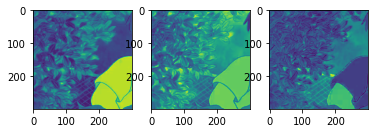

In [127]:
# 컬러 이미지 : 3채널(RGB)
# 주의 ) 원래 OpenCV는 컬러 이미지를 BGR 순서로 저장
# 하지만, 위에서 이미지(img)를 불러올 때, RGB 순서로 바꿔주었기 때문에
# 현재는 보편적으로 아는 RGB 순서!

img_left_crop_r = img_left_crop[:, :, 0]  # R
img_left_crop_g = img_left_crop[:, :, 1]  # G
img_left_crop_b = img_left_crop[:, :, 2]  # B

# 원본 이미지의 R, G, B 채널의 이미지 확인
plt.subplot(1, 3, 1)
plt.imshow(img_left_crop_r)
plt.subplot(1, 3, 2)
plt.imshow(img_left_crop_g)
plt.subplot(1, 3, 3)
plt.imshow(img_left_crop_b)
plt.show()

In [128]:
print(img_left_crop_r.shape)
print(img_left_crop_g.shape)
print(img_left_crop_b.shape)

(300, 300)
(300, 300)
(300, 300)


In [129]:
# 그림 순서대로 R, G, B 채널에 해당되는 이미지값이다.

# 각각 채널, 가우시안 필터가 적용된 엣지의 픽셀값
print("R 채널에 해당되는 픽셀값의 일부분")
print(np.array(img_left_crop_r[:5]))
print("G 채널에 해당되는 픽셀값의 일부분")
print(np.array(img_left_crop_g[:5]))
print("B 채널에 해당되는 픽셀값의 일부분")
print(np.array(img_left_crop_b[:5]))
print("가우시안 필터가 적용된 엣지의 일부분")
print(edges_left_after_gaussian[:5])

R 채널에 해당되는 픽셀값의 일부분
[[ 91  98  99 ... 158 152 156]
 [ 96 100 100 ... 158 150 156]
 [103 100  98 ... 161 153 156]
 [100  93  92 ... 165 145 152]
 [ 80  80  89 ... 171 174 167]]
G 채널에 해당되는 픽셀값의 일부분
[[135 142 143 ... 184 178 182]
 [141 144 144 ... 184 176 182]
 [146 143 141 ... 186 180 182]
 [143 136 135 ... 191 171 178]
 [121 121 131 ... 197 195 188]]
B 채널에 해당되는 픽셀값의 일부분
[[ 45  52  55 ...  86  88  91]
 [ 50  54  56 ...  86  85  91]
 [ 65  62  58 ...  88  89  91]
 [ 62  55  52 ...  93  81  88]
 [ 50  50  56 ...  97 106  99]]
가우시안 필터가 적용된 엣지의 일부분
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  8 10 10]
 [ 0  0  0 ... 18 21 22]
 [29 28 18 ... 37 51 54]]


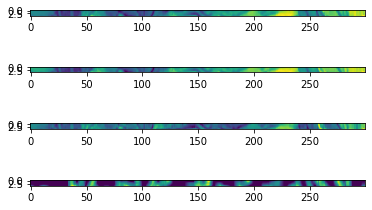

In [130]:
# 각각 채널, 가우시안 필터가 적용된 엣지의 이미지
plt.subplot(4, 1, 1)
plt.imshow(img_left_crop_r[:5])
plt.subplot(4, 1, 2)
plt.imshow(img_left_crop_g[:5])
plt.subplot(4, 1, 3)
plt.imshow(img_left_crop_b[:5])
plt.subplot(4, 1, 4)
plt.imshow(edges_left_after_gaussian[:5])
plt.show()

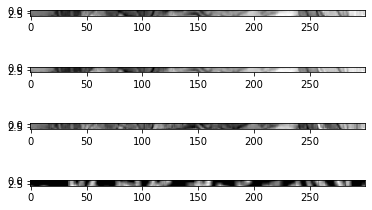

In [131]:
# 픽셀이 없는 값이 보라색으로 보여서 헷갈리므로 회색조로 봐보자.

plt.subplot(4, 1, 1)
plt.imshow(img_left_crop_r[:5], "gray")
plt.subplot(4, 1, 2)
plt.imshow(img_left_crop_g[:5], "gray")
plt.subplot(4, 1, 3)
plt.imshow(img_left_crop_b[:5], "gray")
plt.subplot(4, 1, 4)
plt.imshow(edges_left_after_gaussian[:5], "gray")
plt.show()

In [132]:
# 이제, 각 채널에서의 엣지를 찾아
# 가우시안 필터가 적용된 엣지로 바꿔주자.

print(img_left_crop_r.shape)

(300, 300)


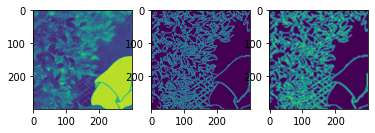

In [133]:
# R채널 원본 그림, 엣지, smoothing된 엣지 비교
plt.subplot(1, 3, 1)
plt.imshow(img_left_crop_r)  # 원본 그림 중 R채널 그림
plt.subplot(1, 3, 2)
plt.imshow(edges_left)  # R채널 그림 중 엣지
plt.subplot(1, 3, 3)
plt.imshow(edges_left_after_gaussian)  # smoothing된 엣지
plt.show()

In [134]:
print(img_left_crop_r.shape)
print(edges_left.shape)
print(edges_left_after_gaussian.shape)
print(img_left_crop_r - edges_left + edges_left_after_gaussian)
temp_temp = img_left_crop_r - edges_left + edges_left_after_gaussian
print(temp_temp.shape)

(300, 300)
(300, 300)
(300, 300)
[[ 91  98  99 ... 158 152 156]
 [ 96 100 100 ... 158 150 156]
 [103 100  98 ... 169 163 166]
 ...
 [ 52  38  54 ...  96  96  96]
 [ 51  37  56 ...  96  96  96]
 [ 54  38  57 ...  96  96  96]]
(300, 300)


In [135]:
# 엣지 smoothing이 된 R, G, B 채널의 이미지
r_smooth = img_left_crop_r - edges_left + edges_left_after_gaussian
g_smooth = img_left_crop_g - edges_left + edges_left_after_gaussian
b_smooth = img_left_crop_r - edges_left + edges_left_after_gaussian

print(r_smooth, r_smooth.shape)
print(g_smooth, g_smooth.shape)
print(b_smooth, b_smooth.shape)

[[ 91  98  99 ... 158 152 156]
 [ 96 100 100 ... 158 150 156]
 [103 100  98 ... 169 163 166]
 ...
 [ 52  38  54 ...  96  96  96]
 [ 51  37  56 ...  96  96  96]
 [ 54  38  57 ...  96  96  96]] (300, 300)
[[135 142 143 ... 184 178 182]
 [141 144 144 ... 184 176 182]
 [146 143 141 ... 194 190 192]
 ...
 [109  95  95 ... 117 117 117]
 [112  98  96 ... 117 117 117]
 [115  99  97 ... 117 117 117]] (300, 300)
[[ 91  98  99 ... 158 152 156]
 [ 96 100 100 ... 158 150 156]
 [103 100  98 ... 169 163 166]
 ...
 [ 52  38  54 ...  96  96  96]
 [ 51  37  56 ...  96  96  96]
 [ 54  38  57 ...  96  96  96]] (300, 300)


[[ 91  98  99 ... 158 152 156]
 [ 96 100 100 ... 158 150 156]
 [103 100  98 ... 169 163 166]
 [100  93  92 ... 183 166 174]
 [109 108 107 ... 208 225 222]]
(300, 300)
[[  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0 255]]
(300, 300)
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  8 10 10]
 [ 0  0  0 ... 18 21 22]
 [29 28 18 ... 37 51 54]]
(300, 300)


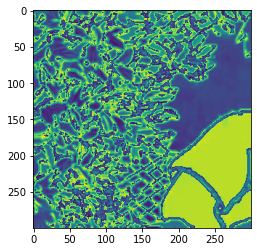

In [136]:
print(r_smooth[:5])
print(r_smooth.shape)
print(edges_left[:5])
print(edges_left.shape)
print(edges_left_after_gaussian[:5])
print(edges_left_after_gaussian.shape)

plt.imshow(r_smooth - edges_left + edges_left_after_gaussian)
plt.show()

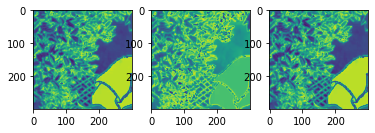

In [137]:
# 엣지 smoothing된 R, G, B 채널 이미지 확인
plt.subplot(1, 3, 1)
plt.imshow(r_smooth)
plt.subplot(1, 3, 2)
plt.imshow(g_smooth)
plt.subplot(1, 3, 3)
plt.imshow(b_smooth)
plt.show()

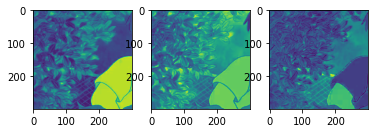

In [138]:
# 엣지 smoothing되지 않은 원본 R, G, B 채널의 이미지 다시 한 번 확인
# 바로 위의 엣지 smoothing된 R, G, B 채널의 이미지와 비교하여
# 엣지 smoothing이 잘 되었는지 확인
plt.subplot(1, 3, 1)
plt.imshow(img_left_crop_r)
plt.subplot(1, 3, 2)
plt.imshow(img_left_crop_g)
plt.subplot(1, 3, 3)
plt.imshow(img_left_crop_b)
plt.show()

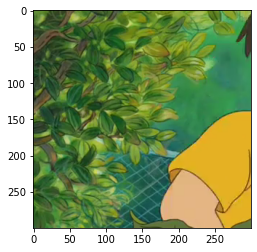

In [139]:
plt.imshow(cv2.merge((img_left_crop_r, img_left_crop_g, img_left_crop_b)))
plt.show()
# 원본 이미지의 R, G, B 채널은 cv2.merge로 채널 병합이 잘 된다.

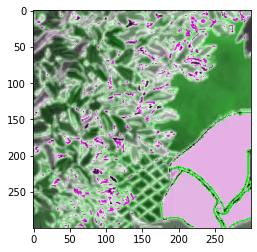

In [140]:
plt.imshow(cv2.merge((r_smooth, g_smooth, b_smooth)))
plt.show()
# 하지만, 엣지 smoothing을 한 R, G, B채널을 하면 이상한 결과가 나온다...
# 이유가 무엇일까...

In [141]:
# 혹시 원본 컬러 이미지(R, G, B 채널이 다 합쳐져있는)의 엣지값을 이용해서 그런가?

# 한번 R, G, B 채널 각각에 해당되는 엣지를 검출하여 그 엣지를 smoothing하고
# 각 채널 - 각 채널의 엣지 + 각 채널의 smoothing된 엣지로 해보자.

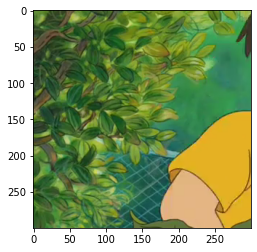

In [142]:
# 원본 이미지 다시 확인
plt.imshow(img_left_crop)
plt.show()

In [144]:
print(np.array(img_left_crop))  # 원본 이미지의 픽셀값 확인
print(img_left_crop.shape)  # 원본 이미지의 shape 확인

[[[ 91 135  45]
  [ 98 142  52]
  [ 99 143  55]
  ...
  [158 184  86]
  [152 178  88]
  [156 182  91]]

 [[ 96 141  50]
  [100 144  54]
  [100 144  56]
  ...
  [158 184  86]
  [150 176  85]
  [156 182  91]]

 [[103 146  65]
  [100 143  62]
  [ 98 141  58]
  ...
  [161 186  88]
  [153 180  89]
  [156 182  91]]

 ...

 [[ 52 109  67]
  [ 38  95  53]
  [ 54  95  53]
  ...
  [ 96 117  60]
  [ 96 117  60]
  [ 96 117  60]]

 [[ 51 112  75]
  [ 37  98  61]
  [ 56  96  62]
  ...
  [ 96 117  62]
  [ 96 117  62]
  [ 96 117  62]]

 [[ 54 115  79]
  [ 38  99  62]
  [ 57  97  63]
  ...
  [ 96 117  62]
  [ 96 117  62]
  [ 96 117  62]]]
(300, 300, 3)


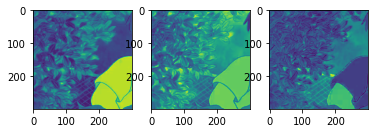

In [146]:
# 각각의 채널(R, G, B)별로 분리
r = img_left_crop[:, :, 0]  # R
g = img_left_crop[:, :, 1]  # G
b = img_left_crop[:, :, 2]  # B

# 주의사항) 원래 OpenCV는 BGR 순서로 저장
# 하지만 맨처음에 이미지를 불러올 때 cv2.cvtColor를 사용하여
# BGR 순서 -> RGB 순서로 바꿔주었다.
# 따라서 지금은 채널 순서가 RGB 순서이다.

# +) 각 채널별로 분할하는 또 다른 방법
# r, g, b = cv2.split(img_left_crop)
# 순서는 img_left_crop의 색상 순서를 그대로 따른다.

plt.subplot(1, 3, 1)
plt.imshow(r)
plt.subplot(1, 3, 2)
plt.imshow(g)
plt.subplot(1, 3, 3)
plt.imshow(b)
plt.show()

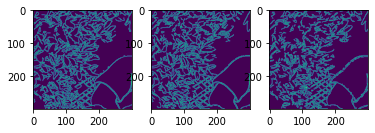

In [149]:
# 각 채널별 엣지 검출하기
r_edges = cv2.Canny(r, 100, 200)
# 엣지 검출할 이미지(R채널 이미지), threshold 최소값, threshold 최대값
g_edges = cv2.Canny(g, 100, 200)
b_edges = cv2.Canny(b, 100, 200)

plt.subplot(1, 3, 1)
plt.imshow(r_edges)
plt.subplot(1, 3, 2)
plt.imshow(g_edges)
plt.subplot(1, 3, 3)
plt.imshow(b_edges)

plt.show()

In [160]:
print(sum(r_edges != g_edges))
print(sum(r_edges != b_edges))
print(sum(g_edges != b_edges))

[11 12 21 21 19 22 14 27 30 18 29 24 14 24 25 24 17 22 14 25 31 21 37 36
 27 19 26 25 29 30 24 32 37 31 26 28 40 35 38 38 29 32 31 30 38 38 43 33
 42 42 42 28 24 23 25 35 37 34 28 25 36 29 30 26 19 31 25 26 47 37 36 40
 42 33 35 36 36 25 30 35 22 38 28 30 24 19 27 32 26 24 23 28 20 19 23 21
 34 34 37 50 36 30 28 39 37 32 39 26 24 20 32 24 30 31 29 28 36 37 37 35
 35 20 24 24 23 32 26 23 32 28 31 36 24 19 25 34 27 26 30 19 21 27 23 21
 28 32 28 29 24 27 20 20 25 28 25 20 33 31 42 34 24 33 28 33 27 22 18 28
 29 23 33 34 34 39 30 32 33 37 26 31 25 28 28 42 36 52 33 34 31 33 20 28
 22 26 13 22 19 21 18 15 13  9  7  8 10 10 11 11 12 15 14 14 13 14 18 22
 26 17 15 19 16 12 10 15 15 18 14 16 17 11 11 15 14 18 14 22 21 20 11 15
  8  7  6  5  5  4  7 11 11 11  6  8  5  3  4  6 12 10  6  6  6  9  7  8
  9  9  5  5  4  5  3  8  4  4  6 10  9  5  8 12  4  5  8  9  9 18 14 12
 11 15 16 28  5 22 17  5  4  9  5  5]
[21 34 29 28 26 20 25 34 40 29 42 31 34 26 28 27 29 30 40 32 32 38 36 38
 25 18 26 22 

In [161]:
# 각각의 채널에 해당하는 엣지값이 동일하다면 결과값이 전부 0으로 나왔을 텐데
# 그렇지 않다.

# 따라서, 각각의 채널마다 엣지의 값이 다르다는 것을 확인.

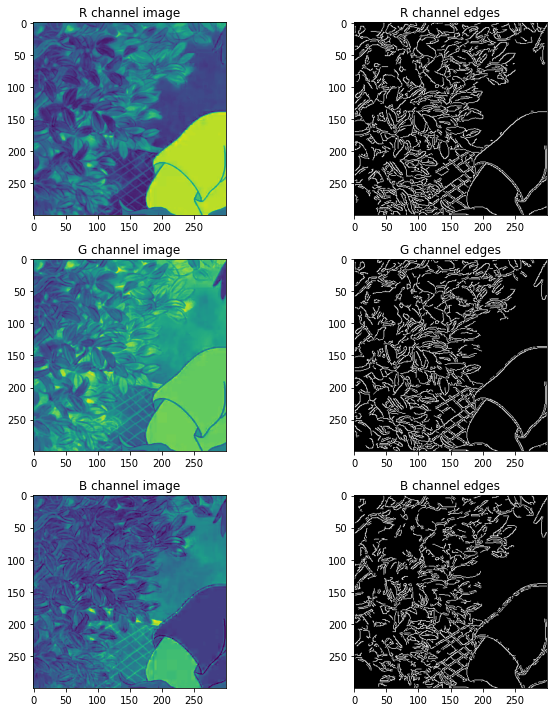

In [172]:
# 각각의 채널, 각각의 채널의 엣지 이미지 비교
plt.figure(figsize=(10, 10))

plt.subplot(3, 2, 1)
plt.imshow(r)
plt.title("R channel image")

plt.subplot(3, 2, 2)
plt.imshow(r_edges, "gray")
plt.title("R channel edges")

plt.subplot(3, 2, 3)
plt.imshow(g)
plt.title("G channel image")

plt.subplot(3, 2, 4)
plt.imshow(g_edges, "gray")
plt.title("G channel edges")

plt.subplot(3, 2, 5)
plt.imshow(b)
plt.title("B channel image")

plt.subplot(3, 2, 6)
plt.imshow(b_edges, "gray")
plt.title("B channel edges")

plt.tight_layout()  # subplot끼리 겹치지 않게 자동조절
plt.show()

In [173]:
# 참고) 엣지는 컬러가 필요없으므로
# 눈에 보기 편하게 회색조로 바꿔서 출력했다.

In [174]:
# 이 정도면 엣지 검출이 잘 된 것 같다.
# 다음 단계로 넘어가자.

In [175]:
# 가우시안 1D 커널 생성
# cv2.getGaussianKernel(kernel size, sigma)
kernel1d = cv2.getGaussianKernel(5, 3)
print(kernel1d)

# 가우시안 2D 커널 생성 : 가우시안 1D 커널을 외적
# np.outer(kernel1d, kernel1d.transpose())
kernel2d = np.outer(kernel1d, kernel1d.transpose())
print(kernel2d)

[[0.17820326]
 [0.21052227]
 [0.22254894]
 [0.21052227]
 [0.17820326]]
[[0.0317564  0.03751576 0.03965895 0.03751576 0.0317564 ]
 [0.03751576 0.04431963 0.04685151 0.04431963 0.03751576]
 [0.03965895 0.04685151 0.04952803 0.04685151 0.03965895]
 [0.03751576 0.04431963 0.04685151 0.04431963 0.03751576]
 [0.0317564  0.03751576 0.03965895 0.03751576 0.0317564 ]]


In [176]:
# 각 채널의 엣지 부분에 가우시안 커널을 적용해주자.
r_edges_gaussian = cv2.filter2D(r_edges, -1, kernel2d)
g_edges_gaussian = cv2.filter2D(g_edges, -1, kernel2d)
b_edges_gaussian = cv2.filter2D(b_edges, -1, kernel2d)

print(r_edges_gaussian)
print(g_edges_gaussian)
print(b_edges_gaussian)

[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  8 10 10]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  8 10 10]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]
[[ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  8 10 10]
 ...
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]
 [ 0  0  0 ...  0  0  0]]


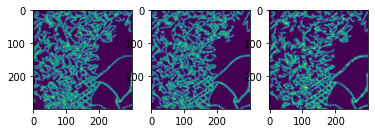

In [178]:
# 각 채널별 smoothing된 엣지 이미지 확인
plt.subplot(1, 3, 1)
plt.imshow(r_edges_gaussian)
plt.subplot(1, 3, 2)
plt.imshow(g_edges_gaussian)
plt.subplot(1, 3, 3)
plt.imshow(b_edges_gaussian)
plt.show()

In [179]:
# 엣지 smoothing이 잘 된 것 같다.

In [180]:
# 엣지 smoothing된 R, G, B 채널의 이미지 생성
r_smooth = r - r_edges + r_edges_gaussian
g_smooth = g - g_edges + g_edges_gaussian
b_smooth = b - b_edges + b_edges_gaussian

print(r_smooth, r_smooth.shape)
print(g_smooth, g_smooth.shape)
print(b_smooth, b_smooth.shape)

[[ 91  98  99 ... 158 152 156]
 [ 96 100 100 ... 158 150 156]
 [103 100  98 ... 169 163 166]
 ...
 [ 52  38  54 ...  96  96  96]
 [ 51  37  56 ...  96  96  96]
 [ 54  38  57 ...  96  96  96]] (300, 300)
[[135 142 143 ... 184 178 182]
 [141 144 144 ... 184 176 182]
 [146 143 141 ... 194 190 192]
 ...
 [109  95  95 ... 117 117 117]
 [112  98  96 ... 117 117 117]
 [115  99  97 ... 117 117 117]] (300, 300)
[[ 45  52  55 ...  86  88  91]
 [ 50  54  56 ...  86  85  91]
 [ 65  62  58 ...  96  99 101]
 ...
 [ 67  53  53 ...  60  60  60]
 [ 75  61  62 ...  62  62  62]
 [ 79  62  63 ...  62  62  62]] (300, 300)


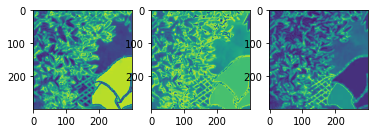

In [181]:
# 엣지 smoothing된 R, G, B 채널의 이미지 확인
plt.subplot(1, 3, 1)
plt.imshow(r_smooth)
plt.subplot(1, 3, 2)
plt.imshow(g_smooth)
plt.subplot(1, 3, 3)
plt.imshow(b_smooth)

plt.show()

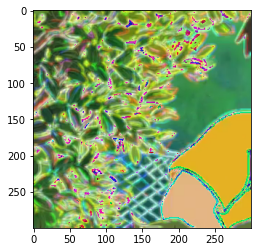

In [185]:
img_left_crop_smooth = cv2.merge((r_smooth, g_smooth, b_smooth))
plt.imshow(img_left_crop_smooth)
plt.show()

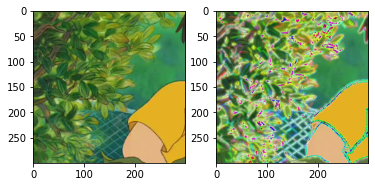

In [186]:
# 원본 이미지와 비교해보자.
plt.subplot(1, 2, 1)
plt.imshow(img_left_crop)
plt.subplot(1, 2, 2)
plt.imshow(img_left_crop_smooth)

plt.show()

In [190]:
# 원본 이미지와 비교하니 엣지가 많이 smoothing된 것을 확인할 수 있다.

# 하지만 엣지 smoothing을 좀 더 자연스럽게 하고 싶은데
# 그러려면 엣지 검출을 할 때 엣지를 너무 많이 검출하지 않게
# threshold 최소값과 threshold 최대값을 조정해야 한다.

# 하지만, 이 테스트해 본 1장의 이미지만 가지고 threshold값을 조정할 수는 없다.
# 따라서, 어떠한 방법이 좋을 지 고민해봐야겠다.